## Задание

Найдите небольшой датасет, подходящий для расширения ImageNet, с классом объектов, которого в ImageNet точно нету, и дообучите готовую модель на этом датасете. Какая точность у вас получится?

**Решение:**

Рассмотрим датасет по предсказанию различных видов бабочек.
  
Ссылка на датасет: https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification

In [2]:
import time
import os
import copy
from __future__ import print_function, division
import shutil

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

plt.ion()

In [3]:
# Configs
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [5]:
# Configs
TRAIN_DATA_PATH = "data_butterfly/train"
TEST_DATA_PATH = "data_butterfly/test"
VAL_DATA_PATH = "data_butterfly/val"

### 1. Read and preprocess initial data

In [6]:
train_dataset = pd.read_csv("data_butterfly/Training_set.csv")
test_dataset = pd.read_csv("data_butterfly/Testing_set.csv")

print("Train dataset shape:", train_dataset.shape)
print("Test dataset shape:", test_dataset.shape)

Train dataset shape: (6499, 2)
Test dataset shape: (2786, 1)


In [7]:
train_dataset["label"] = train_dataset["label"].str.lower()
train_dataset["label"].nunique()

75

### 2. Prepare modeling datasets

#### 2.1. Train/Val splitting

In [8]:
X_train, X_val = train_test_split(train_dataset, test_size=0.15, stratify=train_dataset["label"])
X_train.shape, X_val.shape

((5524, 2), (975, 2))

In [9]:
# Create folder with val images
def move_files_to_folder(source_folder: str, destination_folder: str, filenames: list):
    """
    Important: Remove directory if already exists 
    """
    if os.path.exists(destination_folder):
        # move files back
        shutil.move(
            src=os.path.join(destination_folder, filename),
            dst=os.path.join(source_folder, filename)
        )
        os.rmdir(destination_folder)
    os.mkdir(destination_folder)
    for filename in filenames:
        shutil.move(
            src=os.path.join(source_folder, filename),
            dst=os.path.join(destination_folder, filename)
        )
    return

def split_files_by_classes(df: pd.DataFrame, source_path: str, destination_path: str):
    if ("filename" not in df.columns) or ("label" not in df.columns):
        raise KeyError("Dataframe must contains columns 'filename' and 'label'")
    for i in df.index:
        class_path = os.path.join(destination_path, df["label"][i])
        if not os.path.exists(class_path):
            os.mkdir(class_path)
        shutil.move(
            src=os.path.join(source_path, df["filename"][i]),
            dst=os.path.join(class_path, df["filename"][i])
        )
    return


def drop_identifier_files(initial_path: str):
    for filename in os.listdir(initial_path):
        if filename.endswith(".Identifier"):
            os.system(f"rm {os.path.join(initial_path, filename)}")
    return

In [11]:
move_files_to_folder(TRAIN_DATA_PATH, VAL_DATA_PATH, X_val["filename"].tolist())

In [13]:
split_files_by_classes(X_train, TRAIN_DATA_PATH, TRAIN_DATA_PATH)
split_files_by_classes(X_val, VAL_DATA_PATH, VAL_DATA_PATH)

drop_identifier_files(TRAIN_DATA_PATH)
drop_identifier_files(VAL_DATA_PATH)

#### 2.2. Prepare modeling datasets

In [14]:
data_transforms = {
    'train': transforms.Compose(
	    [
	        transforms.RandomResizedCrop(224),
	        transforms.RandomHorizontalFlip(),
	        transforms.ToTensor(),
	        transforms.Normalize(
		        [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
		    )
	    ]
	),
    'val': transforms.Compose(
	    [
		    transforms.Resize(256),
		    transforms.CenterCrop(224),
		    transforms.ToTensor(),
		    transforms.Normalize(
			    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
			)
		]
	),
}

In [15]:
train_images = ImageFolder(
    TRAIN_DATA_PATH,
    transform=data_transforms["train"]
)
val_images = ImageFolder(
    VAL_DATA_PATH,
    transform=data_transforms["val"]
)

In [16]:
trainloader = torch.utils.data.DataLoader(dataset=train_images, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(dataset=val_images, batch_size=64, shuffle=True)

In [17]:
len(train_images.classes)

75

In [18]:
len(val_images.classes)

75

### 3. Fit model

In [19]:
class AdditionalLayers(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(512, 128) 
        self.linear2 = nn.Linear(128, 75) # 75 classes for butterfly dataset
    
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [20]:
model =  models.resnet18(pretrained=True).to(device)

print(model)

/home/slava/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/slava/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
additional_model = AdditionalLayers().to(device)
print(additional_model)

AdditionalLayers(
  (linear1): Linear(in_features=512, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=75, bias=True)
)


In [22]:
model.fc = additional_model

In [23]:
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
train_loss = []
val_loss = []

epochs = 5

for epoch in range(epochs):
    print("epoch {}/{}".format(epoch+1,epochs))
    running_loss = 0.0
    running_score = 0.0
    for image, label in trainloader:
        image = image.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        y_pred = model.forward(image)
        loss = criterion(y_pred, label)         
        loss.backward() # calculate derivatives 
        optimizer.step() # update parameters
        val, index_ = torch.max(y_pred, axis=1)
        running_score += torch.sum(index_ == label.data).item()
        running_loss += loss.item()
        
    epoch_score = running_score / len(trainloader.dataset)
    epoch_loss = running_loss / len(trainloader.dataset)
    train_loss.append(epoch_loss)
    print("Training loss: {}, accuracy: {}".format(epoch_loss, epoch_score))
  
    with torch.no_grad():
        model.eval()
        running_loss = 0.0
        running_score = 0.0
        for image, label in valloader:
            image = image.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            y_pred = model.forward(image)
            loss = criterion(y_pred, label)
            running_loss += loss.item()

            val, index_ = torch.max(y_pred, axis=1)
            running_score += torch.sum(index_ == label.data).item()
            
        epoch_score = running_score / len(valloader.dataset)
        epoch_loss = running_loss / len(valloader.dataset)
        val_loss.append(epoch_loss)
        print("Validation loss: {}, accuracy: {}".format(epoch_loss, epoch_score))

epoch 1/5
Training loss: 0.0566727658443741, accuracy: 0.21850108616944244
Validation loss: 0.039312229401026015, accuracy: 0.5312820512820513
epoch 2/5
Training loss: 0.03142637228033492, accuracy: 0.5581100651701666
Validation loss: 0.020703733884371245, accuracy: 0.718974358974359
epoch 3/5
Training loss: 0.021454615827318037, accuracy: 0.6663649529326575
Validation loss: 0.01495029969093127, accuracy: 0.7692307692307693
epoch 4/5
Training loss: 0.017186433411352363, accuracy: 0.7266473569876901
Validation loss: 0.01314560755705222, accuracy: 0.7825641025641026
epoch 5/5
Training loss: 0.014968867020534486, accuracy: 0.7501810282404056
Validation loss: 0.011281757813233595, accuracy: 0.798974358974359


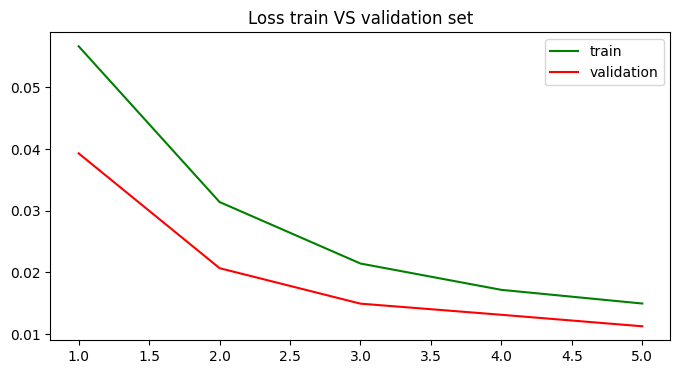

In [26]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(train_loss)+1), train_loss, label="train", color="green")
plt.plot(range(1, len(val_loss)+1), val_loss, label="validation", color="red")
plt.title("Loss train VS validation set")
plt.legend()
plt.show()